# Find Similar Faces in CelebA Kaggle Dataset

## Prerequisites.
 - Access to an ApertureDB instance.
 - aperturedb-python installed.
 - PyTorch installed
 - Setup the Kaggle API (Refer to [Readme](https://github.com/Kaggle/kaggle-api))
 - Install all the dependencies from [requirements.txt](https://github.com/aperture-data/aperturedb-python/blob/main/requirements.txt)


## Introduction
The following notebook explains how to use ApertureDB's built in similarity search feature. 

The notebook also introduces an interface to ingest data from public datasets available on Kaggle.

Furthermore, it serves as an end to end example for the way in which the following common interactions with a typical DB happen:

1. Data ingestion (and enhancement on the fly)
1. Introduction to ApertureDB Parallel loader
1. Data query based on:
  - metadata (queries like find faces that match a certain criteria)
  - embeddings (aka vector search)


### Common imports, definitions and their relavance.
- [dbinfo](https://github.com/aperture-data/aperturedb-python/blob/develop/examples/dbinfo.py) : Essential parmameters to connect to an instance of ApertureDB.

- [facenet](https://github.com/aperture-data/aperturedb-python/blob/main/examples/similarity_search/facenet.py) : This relies on a [model](https://github.com/timesler/facenet-pytorch) that is used to generate embeddings that are generated when ingesting images from CelebA Dataset.

    ```from facenet import generate_embedding```

- [CelebADataKaggle](https://github.com/aperture-data/aperturedb-python/blob/main/examples/CelebADataKaggle.py) : This is the traslation layer that converts the images on [CelebA Dataset on kaggle](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset) into the queries that lead to persisting of those set of images and their meta data into ApertureDB. *Along the way, it also **generates embeddings using facenet** that are used to query on the basis of similarity*.

    ```from CelebADataKaggle import CelebADataKaggle```

In [1]:
#Define some common variables.
import dbinfo
from facenet import generate_embedding
from CelebADataKaggle import CelebADataKaggle


search_set_name = "similar_celebreties"

  0%|          | 0.00/107M [00:00<?, ?B/s]

## Data ingestion

### DescriptorSets and Descriptors

DescriptorSets are sets of feature vectors (embeddings), which are extracted using the same algorithm. These are essential building blocks to ensure that the search we intend to perform is 'apples' to 'apples'.

The term 'Descriptors' and 'Feature Vectors' are used interchangeably in the context of the Query language.

For more details on these two ApertureDB concepts, refer to the following links
- [DescriptorSets](/query_language/Reference/descriptor_commands/desc_set_commands/AddDescriptorSet) 
- [Descriptors](/query_language/Reference/descriptor_commands/desc_commands/AddDescriptor)

### Set up a clean slate

In [2]:
from aperturedb import Utils


con = dbinfo.create_connector()
utils = Utils.Utils(con)
utils.remove_descriptorset(search_set_name)
utils.add_descriptorset(search_set_name, 512, 
    metric=["L2"], engine="FaissFlat")

errors = 0

### Load Kaggle dataset into ApertureDB.
This step uses a dataset celebA, which is available on Kaggle, and ingests it into ApertureDB.

Also, specifically for the purpose of facilitating similarity search, we generate feature vectors for all the images of this dataset. 
While ingesting the dataset, the corresponding feature vectors are added to the DescriptorSet we created earlier.

For the purpose of explaining the feature, we do not ingest the entire set of images in celebA (which are upwards of 200k), but take in 10000 from there.

[ParallelLoader](/python_sdk/parallel_exec/ParallelLoader) is ApertureDB's mechanism to speed things up. Here is it's [source code](https://github.com/aperture-data/aperturedb-python/blob/develop/aperturedb/ParallelLoader.py)

In [4]:
from aperturedb.ParallelLoader import ParallelLoader


dataset = CelebADataKaggle(
        records_count=10000,
        embedding_generator=generate_embedding,
        search_set_name=search_set_name
        )
print(len(dataset))

# Ingest from the dataset created previously using a ParallelQuery.
loader = ParallelLoader(dbinfo.create_connector())
loader.ingest(dataset, stats=True)

10000
Progress: 100.00% - ETA(s): 0.20
============ ApertureDB Loader Stats ============
Total time (s): 502.26145029067993
Total queries executed: 10000
Avg Query time (s): 0.008910035610198975
Query time std: 0.006625592504128772
Avg Query Throughput (q/s): 448.93198804069357
Overall insertion throughput (element/s): 19.909949278831927
Total inserted elements: 10000
Total successful commands: 30000


## Query examples


### Inspect a sample of the data that has been ingested into ApertureDB

CelebA Dataset has lots of metadata such as booleans for attributes such as
- Arched_Eyebrows
- Attractive
- Bags_Under_Eyes
- Bald

[Complete list](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset?select=list_attr_celeba.csv)


Lets search for folks with receding hairline.

Images in the DB = 133287


,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,partition,righteye_x,righteye_y,rightmouth_x,rightmouth_y,type,width,x_1,y_1,yfcc_id
0,-1,-1,-1,1,1,-1,1,1,-1,-1,...,0,106,110,103,153,None,143,194,28,None
1,-1,-1,-1,1,1,-1,-1,1,-1,-1,...,0,110,112,113,150,None,182,221,51,None
2,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,...,0,108,110,104,151,None,78,69,37,None
3,-1,-1,-1,-1,1,-1,1,1,-1,-1,...,0,108,111,108,153,None,114,39,21,None
4,-1,-1,-1,-1,1,-1,-1,1,-1,-1,...,0,106,110,104,155,None,75,124,10,None


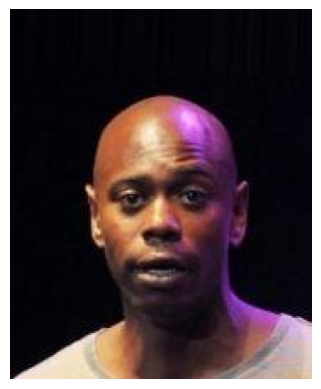

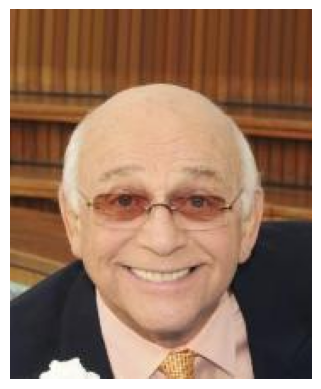

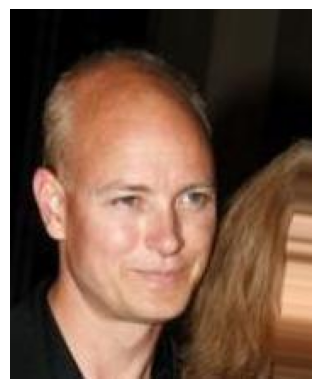

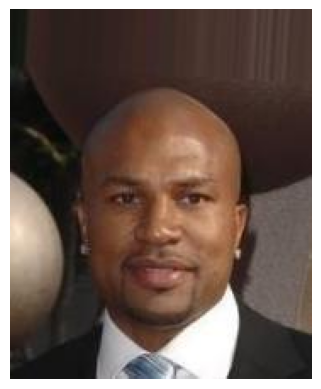

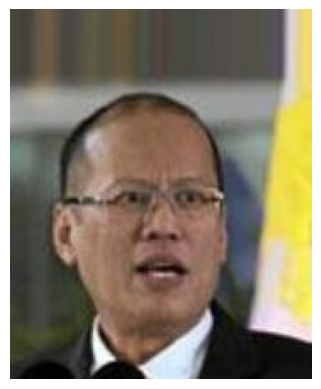

In [5]:
from aperturedb import Images, Utils
import pandas as pd
from aperturedb.Constraints import Constraints

con = dbinfo.create_connector()
utils = Utils.Utils(con)

print(f"Images in the DB = {utils.count_images()}")

images = Images.Images(con)

images.search(limit=5, constraints=Constraints().equal("Bald", 1))

images.display(show_bboxes=False)

pd.json_normalize(images.get_properties(images.get_props_names()).values())

### Find an image which is similar to the images ingested, but not in the DB.

Let's pick some publicly available image, and generate it's feature vector using the same algorithm as used for ingestion.
Our database consists of around ~10000 images of people worldwide, which is not that big.
But if this is completely ingested, we should see more relavant matching images.

*Fun experiment : Upload your photo and see which celebrety you resemble*


/home/ubuntu/Projects/aperturedb-python/env/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


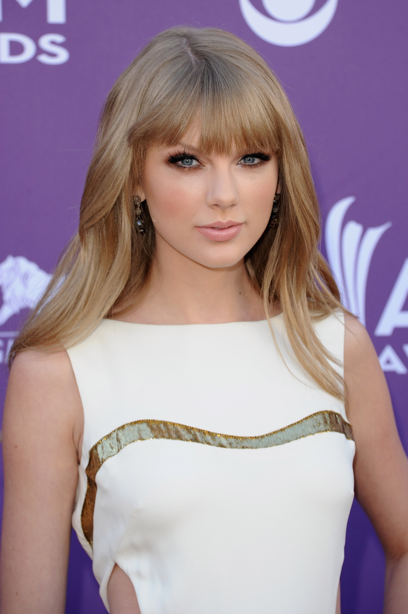

[{'FindDescriptor': {'entities': [{'_distance': 0.5701582431793213, '_id': 8997, '_name': 'similar_celebreties', '_uniqueid': 26995}, {'_distance': 0.6319935321807861, '_id': 5897, '_name': 'similar_celebreties', '_uniqueid': 17695}, {'_distance': 0.7393477559089661, '_id': 3159, '_name': 'similar_celebreties', '_uniqueid': 9481}, {'_distance': 0.7498405575752258, '_id': 2273, '_name': 'similar_celebreties', '_uniqueid': 6823}, {'_distance': 0.7879961133003235, '_id': 5884, '_name': 'similar_celebreties', '_uniqueid': 17656}], 'returned': 5, 'status': 0}}, {'FindImage': {'blobs_start': 0, 'entities': [{'_uniqueid': 26993}, {'_uniqueid': 17693}, {'_uniqueid': 9479}, {'_uniqueid': 6821}, {'_uniqueid': 17654}], 'returned': 5, 'status': 0}}]
26993
17693
9479
6821
17654


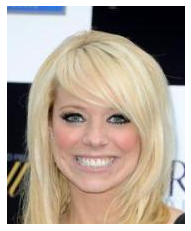

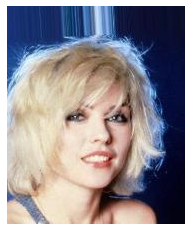

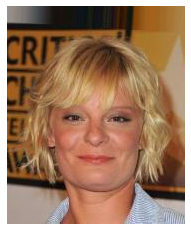

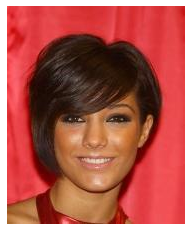

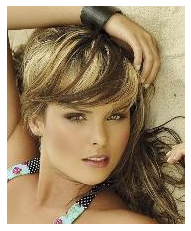

In [6]:
from IPython.display import display
from PIL import Image
#This query finds descriptors that are closest distance to the input sample.
# Further it finds images connected to those descriptors and displays them.
q = [{
    "FindDescriptor": {
        "set": search_set_name,
        "k_neighbors": 5,
        "distances": True,
        "blobs": False,
        "results":{
            "all_properties": True
        },
        "_ref": 1
    }
}, {
    "FindImage": {
        "is_connected_to": {
            "ref": 1,
        },
        "results": {
            "list": ["_uniqueid"]
        }
    }
}]

image_name = "taylor-swift.jpg" # or try with taylor-swift.jpg/bruce-lee.jpg
embedding = generate_embedding(Image.open(image_name).convert('RGB'))
r, b = con.query(q, [embedding.cpu().detach().numpy().tobytes()])
pilImage = Image.open(image_name)
display(pilImage.resize( (int(pilImage.width * 0.3), int(pilImage.height * 0.3)) ))
print(r)
data = pd.json_normalize(r[1]['FindImage']['entities'])


imgs = Images.Images(con)
for d in data['_uniqueid']:
    print(d)
    imgs.images_ids.append(d)

imgs.display()
